In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, r2_score, roc_auc_score, roc_curve, auc
from IPython.display import display
import warnings 

pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

In [2]:
from python_files import *
from python_files.confusion_matrix_func import *
from python_files.display_predictor_func import *

# Predicting instances of majority casual riders usng logistic regressions

- Majority casual riders is 'rare event' constitutes ~ 2% of data records
- Oversampled data with SMOTE package to make-up for imbalance
- 80% train, 20% test
- Treat day of week, time of day (hour) as a categorical

# Target Variable

- 'higher_casual' - column of zeros and ones, one indicates higher percentage of casual (non-subscription) riders than registered (subscription) riders for a given hour.  

# Predictor variables

In [3]:
display_predictors()

Index(['holiday', 'weekday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_2', 'season_3', 'season_4', 'weathersit_1', 'weathersit_2',
       'weathersit_3', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5',
       'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13',
       'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21',
       'hr_22', 'hr_23'],
      dtype='object')

standard AUC for balanced: 0.8327646634026118


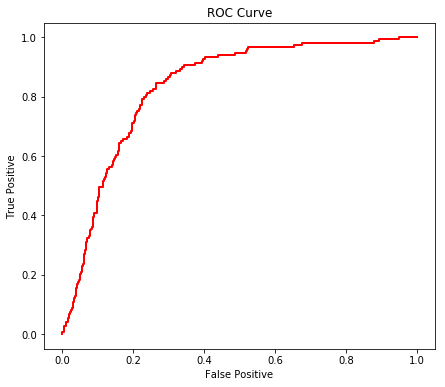

In [4]:
%run -i python_files/log_reg_plot_func.py

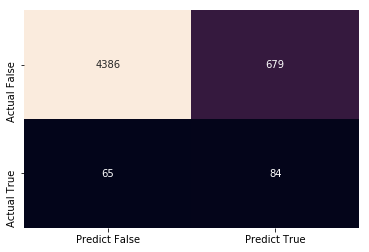

In [5]:
generate_conf_matrix(model_log, X_test, y_test)

# Import Data

In [ ]:
hour_raw = pd.read_csv('data/hour.csv')

# Explore

In [ ]:
hour_raw.describe()

weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

## Month and Season are duplicative - We'll keep the one that correlates more with cnt bike shares   -    looks like season has higher correlation.  

In [ ]:
hour_raw.corr()

In [ ]:
ax = sns.heatmap(hour_raw.corr())

In [ ]:
pd.plotting.scatter_matrix(hour_raw[['temp', 'casual','registered','cnt']])

## Check predictors/targets for normality

In [ ]:
hour_raw[['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum',
         'windspeed', 'cnt']].hist(figsize=(12,10))

## Apply transformations to windspeed and cnt to bring closer to normal

In [ ]:
hour_raw['sqr_wind'] = hour_raw.windspeed**(1/2)
hour_raw['sqr_cnt'] = hour_raw.cnt**(1/5)
hour_raw[['windspeed', 'sqr_wind', 'sqr_cnt', 'cnt']].hist(figsize=(12,8))

# Linear Regression First Attempt - normalized hour data as norm_hr, hour is kept numeric

In [ ]:
hour_raw = pd.read_csv('data/hour.csv')
#hour_raw['sqr_wind'] = hour_raw.windspeed**(1/2)

season_dummies = pd.get_dummies(data=hour_raw.season, prefix='season')
weathersit_dummies=pd.get_dummies(data=hour_raw.weathersit, prefix='weathersit')
weekday_dummies = pd.get_dummies(data=hour_raw.weekday, prefix='weekday')

hour_raw = pd.concat([hour_raw, season_dummies, weathersit_dummies, weekday_dummies], axis=1)
hour_raw.drop(columns=['season_1', 'weathersit_4', 'weekday_6'], inplace = True)

hour_raw['norm_hr'] = (hour_raw.hr-min(hour_raw.hr))/(max(hour_raw.hr)-min(hour_raw.hr))

lin_target = hour_raw.cnt
features_df = hour_raw.drop(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'weathersit', 'atemp', 'casual', 'registered', 'cnt'], axis=1)
predictor_int = sm.add_constant(features_df)

X_train, X_test, y_train, y_test = train_test_split(features_df, lin_target, test_size = 0.4)

model = sm.OLS(y_train, X_train).fit()
model.summary()

Predictors -> season, hr, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt, spring, summer, fall

# linear regression nth attempt - changed hours to dummy vars, transform wind speed, transform target

## Test/train R^2 are very close, ~ .79 much higher now that we are using variable transforms and treating hour as categorical

In [ ]:
hour_raw = pd.read_csv('data/hour.csv')

season_dummies = pd.get_dummies(data=hour_raw.season, prefix='season')
weathersit_dummies=pd.get_dummies(data=hour_raw.weathersit, prefix='weathersit')
weekday_dummies = pd.get_dummies(data=hour_raw.weekday, prefix='weekday')
hr_dummies = pd.get_dummies(data=hour_raw.hr, prefix='hr')

hour_raw = pd.concat([hour_raw, season_dummies, weathersit_dummies, weekday_dummies, hr_dummies], axis=1)
hour_raw.drop(columns=['season_1', 'weathersit_4', 'weekday_6','hr_0'], inplace = True)

hour_raw['sqr_wind'] = hour_raw.windspeed**(1/2)
hour_raw['sqr_cnt'] = hour_raw.cnt**(1/5)

lin_target = hour_raw.sqr_cnt
features_df = hour_raw.drop(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'weathersit', 'atemp', 'casual', 'registered', 'cnt', 'hr', 'sqr_wind', 'sqr_cnt'], axis=1)
predictor_int = sm.add_constant(features_df)

X_train, X_test, y_train, y_test = train_test_split(predictor_int, lin_target, test_size = 0.2)

model = sm.OLS(y_train, X_train).fit()
y_pred = model.predict(X_test)
print('test r2', r2_score(y_test, model.predict(X_test))) 
print('train r2', r2_score(y_train, model.predict(X_train)))

#model.summary()

## Need to transform results back to original form (x^(1/5))^5 = x 
## Check residuals for normality - residuals appear approx normal

In [ ]:
pd.DataFrame(model.predict(X_test)**5-y_test**5).hist(bins=40)
plt.title('residuals normality plot')
plt.savefig('images/lin_reg_resid_normality_plot.jpg')

# LOGISTIC REGRESSION

AUC for balanced: 0.8304119336728033


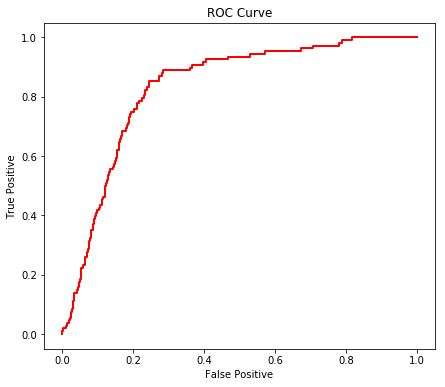

In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

hour_raw = pd.read_csv('data/hour.csv')

season_dummies = pd.get_dummies(data=hour_raw.season, prefix='season')
weathersit_dummies=pd.get_dummies(data=hour_raw.weathersit, prefix='weathersit')
weekday_dummies = pd.get_dummies(data=hour_raw.weekday, prefix='weekday')
hr_dummies = pd.get_dummies(data=hour_raw.hr, prefix='hr')

hour_raw = pd.concat([hour_raw, season_dummies, weathersit_dummies, weekday_dummies, hr_dummies], axis=1)
hour_raw.drop(columns=['season_1', 'weathersit_4', 'weekday_6','hr_0'], inplace = True)

# modify wind/cnt to normalize
hour_raw['sqr_wind'] = hour_raw.windspeed**(1/2)
hour_raw['sqr_cnt'] = hour_raw.cnt**(1/5)

#create target var for Log Reg (more casual or not)
hour_raw['higher_casual'] = [1 if hour_raw['casual'][x]/hour_raw['cnt'][x] >= .5 else 0 for x in list(range(0,len(hour_raw)))] 


logR_target = hour_raw['higher_casual']
predictor_int_log = hour_raw.drop(['instant', 'dteday', 'season', 'yr', 
                                   'mnth', 'hr', 'weathersit', 'atemp', 'casual', 
                                   'registered', 'cnt', 'hr', 'sqr_wind', 'sqr_cnt', 
                                   'higher_casual'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(predictor_int_log, logR_target, test_size = 0.3, random_state=79703)

smote = SMOTE(random_state=2927)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
logreg = LogisticRegression(fit_intercept = True, max_iter=400, C = .01, solver ='lbfgs', random_state=1214) #Starter code
model_log = logreg.fit(X_train_resampled, y_train_resampled)

y_hat_test = logreg.predict(X_test)
y_score = model_log.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
print('AUC for {}: {}'.format('balanced', auc(fpr, tpr)))
lw = 2

fig = plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='red', lw=lw, label='ROC curve {}'.format('balanced'))
plt.title('ROC Curve')
plt.xlabel('False Positive')
plt.ylabel('True Positive')

plt.savefig('images/log_roc_curve.jpg')

In [145]:
predictor_int_log.columns

Index(['holiday', 'weekday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_2', 'season_3', 'season_4', 'weathersit_1', 'weathersit_2',
       'weathersit_3', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5',
       'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13',
       'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21',
       'hr_22', 'hr_23'],
      dtype='object')

## Confusion matrix

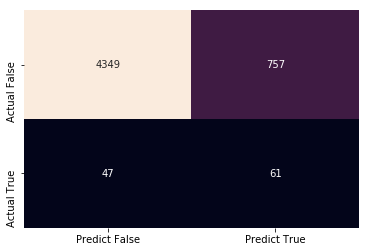

In [146]:
preds = np.where(model_log.predict_proba(X_test)[:,1] > .6, 1, 0)
cm_df = pd.DataFrame(confusion_matrix(y_test, preds), index = ['Actual False', 'Actual True'],
             columns = ['Predict False', 'Predict True'])
sns.heatmap(cm_df, annot=True, cbar=False, fmt='d')
plt.savefig('images/confusion_matrix.jpg')

## Combine predictors and coefficients into one DataFrame and filter on top predictors

In [142]:
log_reg_coefs = pd.DataFrame(X_train.columns, columns=['predictor'])
log_reg_coefs['log_coefs'] = model_log.coef_.transpose()
log_reg_coefs['transformed_coefs'] = math.e**log_reg_coefs.log_coefs
log_reg_coefs.loc[((log_reg_coefs['transformed_coefs']>2) | (log_reg_coefs[
    'transformed_coefs']<-2)) ,:].sort_values(by='transformed_coefs', ascending=False)
log_reg_coefs.sort_values(by='transformed_coefs', ascending=False)

,predictor,log_coefs,transformed_coefs
20,hr_3,2.066365,7.896067
19,hr_2,1.967425,7.152238
21,hr_4,1.908866,6.745437
18,hr_1,0.750830,2.118758
0,holiday,0.729956,2.074990
32,hr_15,0.683923,1.981637
30,hr_13,0.435117,1.545144
31,hr_14,0.399857,1.491611
3,temp,0.391316,1.478926
4,hum,0.372190,1.450908


In [ ]:
hour_raw.

In [143]:
import math
from math import exp
from math import e
trials = pd.DataFrame(np.linspace(-2,2,11), columns=['tri'])
trials['results'] = math.e**trials.tri/(1+math.e**trials.tri)
trials
# prod.append
# pro = []
# for x in trials:
#     prod.append(exp(x)/(1+exp(x)))
# prod

,tri,results
0,-2.0,0.119203
1,-1.6,0.167982
2,-1.2,0.231475
3,-0.8,0.310026
4,-0.4,0.401312
5,0.0,0.500000
6,0.4,0.598688
7,0.8,0.689974
8,1.2,0.768525
9,1.6,0.832018
